# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

try:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
except:
    print('/opt/ros/kinetic/lib/python2.7/dist-packages, not found')
    
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


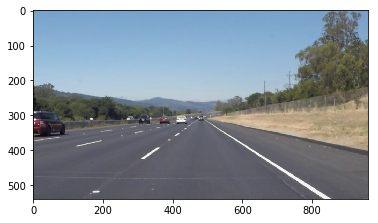

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
#plt.imshow(image, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [234]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def reject_outliers(data, d=.1):
    m = 2
    u = np.median(data)
    filtered = [e for e in data if (abs(u-e) < d)]
    return filtered

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #print('lines type', type(lines))
    for line in lines:
        #print('line type', type(line))
        #print(line)
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def crawford_lines(lines, image):
    # calculate positive and negative slopes and y-intercepts
    m_pos = []
    b_pos = []
    m_neg = []
    b_neg = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1) / (x2-x1)
            b = -m*x1+y1
            if m > 0:
                m_pos.append(m)  
                b_pos.append(b)
            else:
                m_neg.append(m)
                b_neg.append(b)

    #try:
    #m_pos = reject_outliers(m_pos,.2)
    #m_neg = reject_outliers(m_neg,.2)
    #b_pos = reject_outliers(b_pos,.2)
    #b_neg = reject_outliers(b_neg,.2)
    #except:
    #    pass
    
    m_pos_avg = np.average(m_pos)
    m_neg_avg = np.average(m_neg)
    b_pos_avg = np.average(b_pos)
    b_neg_avg = np.average(b_neg)
    
    print('std m pos', np.std(m_pos))
    print('std m pos', np.std(m_neg))

    # determine average lines
    y1 = int(mask_top_y)
    #print('y1',y1)
    #print('b_pos_avg',b_pos_avg)
    #print('m_pos_avg',m_pos_avg)  
    try:
        x1 = int((y1 - b_pos_avg) / m_pos_avg)
        y2 = int(mask_bottom_y)
        x2 = int((y2 - b_pos_avg) / m_pos_avg)
    except:
        x1 = 0
        y2 = 0
        x2 = 0
    pos_line = []
    pos_line.append(x1)
    pos_line.append(y1)
    pos_line.append(x2)
    pos_line.append(y2)
    pl = np.array([pos_line])

    y1 = int(mask_top_y)
    #print('y1',y1)
    #print('b_neg_avg',b_neg_avg)
    #print('m_neg_avg',m_neg_avg)
    try:
        x1 = int((y1 - b_neg_avg) / m_neg_avg)
        y2 = int(mask_bottom_y)
        x2 = int((y2 - b_neg_avg) / m_neg_avg)
    except:
        x1 = 0
        y2 = 0
        x2 = 0
    neg_line = []
    neg_line.append(x1)
    neg_line.append(y1)
    neg_line.append(x2)
    neg_line.append(y2)
    nl = np.array([neg_line])


    combined_lines = np.array([nl, pl])   
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, combined_lines, [255,0,0], 10)
    
    return weighted_img(line_img, image, α=0.8, β=1., λ=0.)    
               

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #print(lines)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

std m pos 0.025358582651
std m pos 0.020332808876


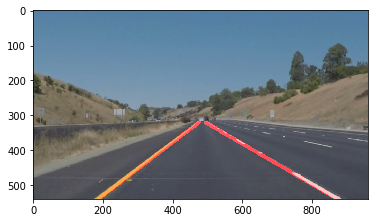

In [230]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# Read in the image and convert to grayscale
# Note: in the previous example we were reading a .jpg 
# Here we read a .png and convert to 0,255 bytescale

kernel_size = 5
low_threshold = 70 #50
high_threshold = 150 #150
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 50 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
mask_top_y = 320
mask_bottom_y = 540

images = os.listdir("test_images/")

# load image to process
image = mpimg.imread("test_images/" + images[0])

# convert image to gray scale
gray = grayscale(image)
plt.imshow(gray, cmap='Greys_r')

#blur image to reduce the influence of noise
blur_gray = gaussian_blur(gray, kernel_size)
#plt.imshow(blur_gray, cmap='Greys_r')

# use canny function to identify edges
edges = canny(blur_gray, low_threshold, high_threshold)
#plt.imshow(edges, cmap='Greys_r')

# add mask to focus on region of interest
# need to revist the paramters for the mask
imshape = image.shape

vertices = np.array([[(0,imshape[0]),(450, mask_top_y), (500, mask_top_y), (imshape[1],imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
plt.imshow(masked_edges, cmap='Greys_r')

# find lines using hugh tansform
line_image = np.copy(image)*0 # creating a blank to draw lines on
lines_edges, lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
#plt.imshow(lines_edges, cmap='Greys_r')

# find average line for each lane side
weighted_image = crawford_lines(lines, image)
plt.imshow(weighted_image, cmap='Greys_r')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [121]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [189]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    kernel_size = 5
    low_threshold = 70 #50
    high_threshold = 150 #150
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    mask_top_y = 320
    mask_bottom_y = 540

    # convert image to gray scale
    gray = grayscale(image)
    plt.imshow(gray, cmap='Greys_r')

    #blur image to reduce the influence of noise
    blur_gray = gaussian_blur(gray, kernel_size)
    #plt.imshow(blur_gray, cmap='Greys_r')

    # use canny function to identify edges
    edges = canny(blur_gray, low_threshold, high_threshold)
    #plt.imshow(edges, cmap='Greys_r')

    # add mask to focus on region of interest
    # need to revist the paramters for the mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, mask_top_y), (500, mask_top_y), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    #plt.imshow(masked_edges, cmap='Greys_r')

    # find lines using hugh tansform
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    lines_edges, lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    #plt.imshow(lines_edges, cmap='Greys_r')

    # find average line for each lane side
    result = crawford_lines(lines, image)
    result = weighted_img(lines_edges, result, α=0.8, β=1., λ=0.) 
    return result

Let's try the one with the solid white lane on the right first ...

std m pos 0.0251338396098
std m pos 0.0221186541315
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  2%|▏         | 4/222 [00:00<00:07, 30.58it/s]

std m pos 0.0251338396098
std m pos 0.0221186541315
std m pos 0.0304245087623
std m pos 0.0177464011569
std m pos 0.0125717987895
std m pos 0.0229331917937
std m pos 0.0119926324051
std m pos 0.0379177513208
std m pos 0.0105808749164
std m pos 0.0318560671252
std m pos 0.0215419816959
std m pos 0.0174331007211


  4%|▎         | 8/222 [00:00<00:07, 29.38it/s]

std m pos 0.019335579311
std m pos 0.0164381771449
std m pos 0.0174046677575
std m pos 0.0470056605806
std m pos 0.0099948399548
std m pos 0.0469560451936
std m pos 0.0212746396703
std m pos 0.0312640028029


  5%|▍         | 11/222 [00:00<00:07, 28.36it/s]

std m pos 0.0250574875324
std m pos 0.02521004088


  7%|▋         | 15/222 [00:00<00:06, 29.68it/s]

std m pos 0.0193906903027
std m pos 0.0462636435963
std m pos 0.0214926221907
std m pos 0.0191920553817
std m pos 0.0144212308613
std m pos 0.0295781234865
std m pos 0.0111238340017
std m pos 0.0333973096356
std m pos 0.0155266123256
std m pos 0.0380719277463
std m pos 0.0243000263897
std m pos 0.0269065118262
std m pos 0.0112066175533
std m pos 0.0220383901831


 10%|▉         | 22/222 [00:00<00:06, 29.76it/s]

std m pos 0.0242839870217
std m pos 0.0170732041277
std m pos 0.0124887707598
std m pos 0.0525125364694
std m pos 0.0156178993733
std m pos 0.0264940652749
std m pos 0.0149407636012
std m pos 0.0772307619736
std m pos 0.0141589025787
std m pos 0.0101940960386
std m pos 0.0290889269247
std m pos 0.0382629016934


 13%|█▎        | 28/222 [00:00<00:06, 28.09it/s]

std m pos 0.0119762312592
std m pos 0.0401001715346
std m pos 0.0112587668515
std m pos 0.0407160472487
std m pos 0.0127814635333
std m pos 0.0296395710119
std m pos 0.0076188359906
std m pos 0.0289674709924
std m pos 0.0133983024542
std m pos 0.0325813567581
std m pos 0.0107004539773
std m pos 0.0259980868288
std m pos 0.0117879312404
std m pos 0.0336697824534


 16%|█▌        | 36/222 [00:01<00:05, 32.00it/s]

std m pos 0.0106433392848
std m pos 0.0443859247402
std m pos 0.011338891541
std m pos 0.0307214027159
std m pos 0.0272525742257
std m pos 0.0385836981478
std m pos 0.0254485175943
std m pos 0.0170698480908
std m pos 0.0427604295908
std m pos 0.0272232671228
std m pos 0.0214037851028
std m pos 0.0295635710417
std m pos 0.0310856297515
std m pos 0.0524024713569
std m pos 0.035618977196
std m pos 0.0169776962278


 20%|█▉        | 44/222 [00:01<00:05, 32.80it/s]

std m pos 0.0112902029079
std m pos 0.0558198592762
std m pos 0.0221417263733
std m pos 0.035859600279
std m pos 0.0117951292987
std m pos 0.0187435540207
std m pos 0.0121072062459
std m pos 0.0140995245084
std m pos 0.0159494643168
std m pos 0.0313436447044
std m pos 0.0237435782513
std m pos 0.021946749143
std m pos 0.0116657286173
std m pos 0.0363082818834


 22%|██▏       | 48/222 [00:01<00:05, 32.10it/s]

std m pos 0.0164212562137
std m pos 0.0356284704065
std m pos 0.0277819795881
std m pos 0.0182203259643
std m pos 0.0315518962854
std m pos 0.0270851002895
std m pos 0.0183055887852
std m pos 0.0373534124889
std m pos 0.0291933699259
std m pos 0.0401717989949


 23%|██▎       | 52/222 [00:01<00:05, 31.03it/s]

std m pos 0.0226751987215
std m pos 0.0294089499868


 25%|██▌       | 56/222 [00:01<00:05, 29.65it/s]

std m pos 0.0256695597738
std m pos 0.0282644274875
std m pos 0.0215081069832
std m pos 0.0260892098397
std m pos 0.0266476396732
std m pos 0.0327261691196
std m pos 0.0529317319165
std m pos 0.00981036010533
std m pos 0.0245659032639
std m pos 0.0333193479739
std m pos 0.024281556232
std m pos 0.0328657670685


 27%|██▋       | 59/222 [00:02<00:07, 21.62it/s]

std m pos 0.0195907687163
std m pos 0.0261602012055


 28%|██▊       | 62/222 [00:02<00:06, 23.12it/s]

std m pos 0.0275596241347
std m pos 0.0273675668466
std m pos 0.0206831312836
std m pos 0.0249333239649
std m pos 0.0131687356602
std m pos 0.0513541089273
std m pos 0.026023590921
std m pos 0.0267105364135
std m pos 0.0230764479949
std m pos 0.0386215129043
std m pos 0.0144592623457
std m pos 0.0212091067074


 31%|███       | 69/222 [00:02<00:05, 25.57it/s]

std m pos 0.0106115969621
std m pos 0.0594181227414
std m pos 0.0162383439396
std m pos 0.00942810092503
std m pos 0.0268250166483
std m pos 0.011914685333
std m pos 0.0106517794625
std m pos 0.0222882239406
std m pos 0.0158778921166
std m pos 0.0266394558209
std m pos 0.0131297194812
std m pos 0.0264193409336


 33%|███▎      | 73/222 [00:02<00:05, 26.50it/s]

std m pos 0.0087024133331
std m pos 0.0213327599768
std m pos 0.0130239134177
std m pos 0.0280829293593
std m pos 0.0135040547275
std m pos 0.026403008221
std m pos 0.0110164666992
std m pos 0.0239845786044


 34%|███▍      | 76/222 [00:02<00:05, 25.13it/s]

std m pos 0.0188349912731
std m pos 0.0248417548905


 36%|███▌      | 79/222 [00:02<00:05, 25.21it/s]

std m pos 0.0195791001874
std m pos 0.0125748312116
std m pos 0.0134306588367
std m pos 0.0346699547644
std m pos 0.029058749814
std m pos 0.0359851057325
std m pos 0.0299127055355
std m pos 0.0242750271961
std m pos 0.0732194247306
std m pos 0.0335940399629


 37%|███▋      | 82/222 [00:02<00:05, 25.83it/s]

std m pos 0.0304359468184
std m pos 0.0365246672644


 38%|███▊      | 85/222 [00:03<00:05, 26.76it/s]

std m pos 0.0315020266081
std m pos 0.029982550424
std m pos 0.0149308287469
std m pos 0.0256090432876
std m pos 0.00913548652919
std m pos 0.0184595096207
std m pos 0.0198358300318
std m pos 0.0283641397112
std m pos 0.0405554795057
std m pos 0.0149131783996


 40%|███▉      | 88/222 [00:03<00:04, 27.28it/s]

std m pos 0.029509941402
std m pos 0.0155302199677


 41%|████      | 91/222 [00:03<00:04, 26.59it/s]

std m pos 0.0312089966879
std m pos 0.0249933704402
std m pos 0.010247584056
std m pos 0.017589515416
std m pos 0.0259299377143
std m pos 0.0229132804302
std m pos 0.0289030535934
std m pos 0.0189833568135
std m pos 0.0346325043698
std m pos 0.0278181649055
std m pos

 44%|████▍     | 98/222 [00:03<00:04, 28.89it/s]

 0.0220289069757
std m pos 0.0217947402388
std m pos 0.0468693559016
std m pos 0.0283223460172
std m pos 0.0286315784511
std m pos 0.0268616481262
std m pos 0.0237713230898
std m pos 0.0231613111506
std m pos 0.0589670036794
std m pos 0.0251374799112
std m pos 0.0279201532183
std m pos 0.0385149830341
std m pos 0.00954314124393
std m pos 0.0303832197667


 47%|████▋     | 104/222 [00:03<00:04, 26.95it/s]

std m pos 0.0303591326273
std m pos 0.0286214124713
std m pos 0.0261027263373
std m pos 0.0174494181383
std m pos 0.0120907137592
std m pos 0.0332316011712
std m pos 0.0127993132236
std m pos 0.013332509887
std m pos 0.0142551069046
std m pos 0.0286786299376
std m pos 0.0223348726528
std m pos 0.0169864849467


 50%|████▉     | 110/222 [00:03<00:04, 27.83it/s]

std m pos 0.0382889279121
std m pos 0.0443786771157
std m pos 0.0129183191756
std m pos 0.0361614893804
std m pos 0.0111859816293
std m pos 0.0255578435001
std m pos 0.0102851401254
std m pos 0.0267111726658
std m pos 0.0127400552565
std m pos 0.0405898395243
std m pos 0.0169884543285
std m pos 0.0343907184923


 52%|█████▏    | 116/222 [00:04<00:03, 27.70it/s]

std m pos 0.0233994286674
std m pos 0.026211771617
std m pos 0.0525894505367
std m pos 0.0235085268199
std m pos 0.0105153399831
std m pos 0.0491735956104
std m pos 0.0280034950708
std m pos 0.0342416007334
std m pos 0.0310981131928
std m pos 0.0343061453037
std m pos 0.0280162320035
std m pos 0.0432719803486


 55%|█████▍    | 122/222 [00:04<00:03, 26.93it/s]

std m pos 0.0469300360331
std m pos 0.0374796511222
std m pos 0.0152370032523
std m pos 0.0260509858946
std m pos 0.0454341122553
std m pos 0.0332214325997
std m pos 0.0240446471213
std m pos 0.024877529241
std m pos 0.0267874678145
std m pos 0.0224623358776
std m pos 0.0290086307159
std m pos 0.0324464017946


 59%|█████▊    | 130/222 [00:04<00:03, 29.95it/s]

std m pos 0.0249163358642
std m pos 0.0305060822688
std m pos 0.0228673662578
std m pos 0.0337845516129
std m pos 0.0166741058289
std m pos 0.0203098675991
std m pos 0.0114795844383
std m pos 0.0673864334033
std m pos 0.0173314281644
std m pos 0.0206243770849
std m pos 0.0139132983369
std m pos 0.0252257735131
std m pos 0.0113587788022
std m pos 0.0445923754331


 62%|██████▏   | 137/222 [00:04<00:03, 27.90it/s]

std m pos 0.0115597984053
std m pos 0.0412547862615
std m pos 0.0333965471424
std m pos 0.0229968212672
std m pos 0.0223306417926
std m pos 0.0242448187898
std m pos 0.0432819434088
std m pos 0.0392680773022
std m pos 0.0102103706632
std m pos 0.0252693938299
std m pos 0.0105953920643
std m pos 0.0150164062906


 64%|██████▎   | 141/222 [00:04<00:02, 29.53it/s]

std m pos 0.0309828742977
std m pos 0.00921937014686
std m pos 0.013362095108
std m pos 0.0361132367638
std m pos 0.0164100269683
std m pos 0.01585326053
std m pos 0.0410935703934
std m pos 0.017396022116
std m pos 0.0126487702435
std m pos 0.0413939039383
std m pos 0.00949733048307
std m pos 0.040905033076
std m pos 0.0200437085185
std m pos 0.0196839894076
std m pos 0.0347454290982
std m pos 0.03122724261


 69%|██████▉   | 153/222 [00:05<00:02, 33.68it/s]

std m pos 0.00998900449871
std m pos 0.0253605964307
std m pos 0.0113967591219
std m pos 0.0290556100786
std m pos 0.0135920955356
std m pos 0.0278498814571
std m pos 0.0178724171308
std m pos 0.040601659495
std m pos 0.0537114064319
std m pos 0.0299862864112
std m pos 0.0201989344975
std m pos 0.0351317247694
std m pos 0.0144780147123
std m pos 0.0267624833771
std m pos 0.0220355050837
std m pos 0.0375257663351


 71%|███████   | 157/222 [00:05<00:01, 32.57it/s]

std m pos 0.014751300669
std m pos 0.0173727391148
std m pos 0.0105264000965
std m pos 0.0349097972823
std m pos 0.0106159976522
std m pos 0.0322473248083
std m pos 0.0220239265343
std m pos 0.0278725734619
std m pos 0.0261294285793
std m pos 0.0257121893836
std m pos 0.0102705497058
std m pos 0.0137922338428
std m pos

 74%|███████▍  | 165/222 [00:05<00:01, 29.44it/s]

 0.012306261405
std m pos 0.0201979810397
std m pos 0.0224285997012
std m pos 0.0470417718438
std m pos 0.0283837967683
std m pos 0.0286226288977
std m pos 0.0330001335581
std m pos 0.010879973707
std m pos 0.0179530017761
std m pos 0.0244821092279
std m pos 0.0122506045122
std m pos 0.0388600875645
std m pos 0.017463158475
std m pos 0.0176414614897


 76%|███████▌  | 169/222 [00:05<00:01, 29.69it/s]

std m pos 0.0117517082583
std m pos 0.0343139639517
std m pos 0.0104705366133
std m pos 0.0245894251745
std m pos 0.010040276708
std m pos 0.041821415137
std m pos 0.0404472690456
std m pos 0.0415762944341
std m pos 0.0100915338183
std m pos 0.0213289395545
std m pos 0.0109490610681
std m pos 0.0730892277399
std m pos 0.0138323186107
std m pos 

 79%|███████▉  | 176/222 [00:06<00:01, 28.71it/s]

0.060869835872
std m pos 0.00886692528962
std m pos 0.0294320564879
std m pos 0.0163279637629
std m pos 0.024927993243
std m pos 0.0195709422189
std m pos 0.0394738058966
std m pos 0.0364124625436
std m pos 0.06590355717
std m pos 0.0162378995445
std m pos 0.0353787674937


 83%|████████▎ | 184/222 [00:06<00:01, 29.49it/s]

std m pos 0.00813684182507
std m pos 0.0325689961021
std m pos 0.0198723483592
std m pos 0.045907123563
std m pos 0.0151286051432
std m pos 0.0365435367489
std m pos 0.0226215710459
std m pos 0.0281662053198
std m pos 0.0183765518954
std m pos 0.0613280784391
std m pos 0.026220933478
std m pos 0.0267824786053


 85%|████████▍ | 188/222 [00:06<00:01, 30.04it/s]

std m pos 0.0230038670218
std m pos 0.0504342685456
std m pos 0.0121737523887
std m pos 0.0167786099938
std m pos 0.0140822687649
std m pos 0.0406896263532
std m pos 0.0220009678215
std m pos 0.0536504642924
std m pos 0.0111012779338
std m pos 0.0299625921459
std m pos 0.0144377761759
std m pos 0.0471664613901
std m pos 0.0241097346751
std m pos 0.0605109635804


 88%|████████▊ | 196/222 [00:06<00:00, 30.13it/s]

std m pos 0.0197066082861
std m pos 0.0557671003809
std m pos 0.0123187253758
std m pos 0.0298113779549
std m pos 0.0626997714319
std m pos 0.0550591085917
std m pos 0.0643488503534
std m pos 0.0346917727927
std m pos 0.0366604115607
std m pos 0.235342886793
std m pos 0.0136943244736
std m pos 0.0614019084489


 91%|█████████▏| 203/222 [00:07<00:00, 29.05it/s]

std m pos 0.00854723402371
std m pos 0.0315017911596
std m pos 0.0529379666955
std m pos 0.0619880691024
std m pos 0.0566174760419
std m pos 0.0891505466779
std m pos 0.0334810526438
std m pos 0.313239445438
std m pos 0.0278665182771
std m pos 0.0389968180376
std m pos 0.0256756894381
std m pos 0.0648162210082
std m pos 0.0194504485431
std m pos 0.0377552714498


 93%|█████████▎| 207/222 [00:07<00:00, 29.55it/s]

std m pos 0.0137598512585
std m pos 0.0521163531731
std m pos 0.0243284826496
std m pos 0.0378673866736
std m pos 0.0163484279566
std m pos 0.0335778746181
std m pos 0.0133460981805
std m pos 0.0328987324167
std m pos 0.00842376826281
std m pos 0.0390206295467
std m pos 0.00819036718882
std m pos 0.0508229694124


 97%|█████████▋| 215/222 [00:07<00:00, 30.00it/s]

std m pos 0.0109292201296
std m pos 0.101730808621
std m pos 0.0199346574489
std m pos 0.0550038421749
std m pos 0.0141235103717
std m pos 0.0641392309938
std m pos 0.0183938774388
std m pos 0.0517753100336
std m pos 0.0105409229967
std m pos 0.0409084654064
std m pos 0.0122272302267
std m pos 0.0366506847134
std m pos 0.00987741055862
std m pos 0.0480295583076


100%|█████████▉| 221/222 [00:07<00:00, 28.97it/s]


std m pos 0.0107990579114
std m pos 0.0298696975309
std m pos 0.035930206551
std m pos 0.0453888723582
std m pos 0.0120498524216
std m pos 0.0483954744885
std m pos 0.0143728171791
std m pos 0.0307682663341
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 38.6 s, sys: 252 ms, total: 38.9 s
Wall time: 8.02 s


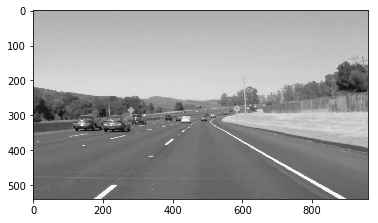

In [237]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [236]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

std m pos 0.0362787760975
std m pos 0.024353897795
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 3/682 [00:00<00:29, 23.12it/s]

std m pos 0.0362787760975
std m pos 0.024353897795
std m pos 0.0319245510306
std m pos 0.0420227203982
std m pos 0.0355400123294
std m pos 0.0368590136862
std m pos 0.0376400971862
std m pos 0.0242473941049
std m pos 0.0347681239259
std m pos 0.0370743134509
std m pos 0.0204490716243
std m pos 0.238728253384


  1%|▏         | 10/682 [00:00<00:25, 26.61it/s]

std m pos 0.0108146067416
std m pos 0.102907132164
std m pos 0.0205853718118
std m pos 0.0160679745072
std m pos 0.0320387280181
std m pos 0.0475616938826
std m pos 0.0267211164142
std m pos 0.0257805189703
std m pos 0.0360157434831
std m pos 0.0174672143823
std m pos 0.0449008601486
std m pos 0.0249338003652


  3%|▎         | 18/682 [00:00<00:23, 28.43it/s]

std m pos 0.0454805763024
std m pos 0.0597772926638
std m pos 0.0379209092794
std m pos 0.0632033697663
std m pos 0.0335511529422
std m pos 0.0625372324543
std m pos 0.031467402072
std m pos 0.0162950026531
std m pos 0.0280033496128
std m pos 0.0292594881732
std m pos 0.229860231961
std m pos 0.0137942620535


  4%|▎         | 25/682 [00:00<00:22, 29.75it/s]

std m pos 0.0515453453527
std m pos 0.0880108719529
std m pos nan
std m pos 0.022316888075
std m pos 0.0154205490026
std m pos 0.0755851700616
std m pos 0.0166939398867
std m pos 0.0704315459966
std m pos 0.0157367618067
std m pos 0.0429591381589
std m pos 0.0347633758989
std m pos 0.0687764496234
std m pos 0.0384636742674
std m pos 0.0950235945726


  4%|▍         | 28/682 [00:00<00:23, 27.56it/s]

std m pos 0.0318744140464
std m pos 0.0129089043417
std m pos 0.0252153472144
std m pos 0.041515475431
std m pos 0.0223582047346
std m pos 0.0252066682264
std m pos 0.0300458602555
std m pos 0.0257107347737
std m pos 0.0299915465433
std m pos 0.0398821150723
std m pos 0.0
std m pos 0.0729868528503


  6%|▌         | 39/682 [00:01<00:21, 29.97it/s]

std m pos nan
std m pos 0.0227470543592
std m pos 0.0
std m pos 0.0489259171449
std m pos 0.0192372825964
std m pos 0.0650709595377
std m pos 0.00459198036936
std m pos 0.0239006301705
std m pos 0.0380848486001
std m pos 0.0305078046708
std m pos 0.0314375822745
std m pos 0.0440296485707
std m pos 0.030720588217
std m pos 0.02177543734
std m pos 0.0254772002099
std m pos 0.0211221544709


  6%|▋         | 43/682 [00:01<00:21, 30.28it/s]

std m pos 0.0347156752879
std m pos 0.0367124682256
std m pos 0.0252401727933
std m pos 0.0385923239338
std m pos 0.0216932330182
std m pos 0.207830518035
std m pos 0.0214285714286
std m pos 0.225123956039


  7%|▋         | 47/682 [00:01<00:30, 21.07it/s]

std m pos nan
std m pos 0.019749826874
std m pos 0.0
std m pos 0.0309298214296
std m pos 0.0119975699883
std m pos 0.0308056059817
std m pos 0.00920868087929
std m pos 0.0400825712098
std m pos 0.0303216963285
std m pos 0.0159983915157
std m pos 0.0274330460606
std m pos 0.0338383446604


  8%|▊         | 53/682 [00:01<00:26, 23.90it/s]

std m pos 0.0140789904839
std m pos 0.0169286229302
std m pos 0.0255708762917
std m pos 0.0248431346433
std m pos 0.0164714509548
std m pos 0.0265564601733
std m pos 0.0394604239059
std m pos 0.0406198776338
std m pos 0.0228482942126
std m pos 0.0580001084608
std m pos 0.0300751245246
std m pos 0.0182062865246


  9%|▊         | 59/682 [00:02<00:24, 25.00it/s]

std m pos 0.0323129251701
std m pos 0.226377073752
std m pos 0.0
std m pos 0.0236949790128
std m pos 0.0221837421549
std m pos 0.040170967632
std m pos 0.0122878451709
std m pos 0.0166353147781
std m pos 0.0209003711966
std m pos 0.0310990743107
std m pos 0.0286341179347
std m pos 0.0148737751279


 10%|▉         | 65/682 [00:02<00:23, 26.38it/s]

std m pos 0.0340268927449
std m pos 0.0243390396953
std m pos 0.0272879674186
std m pos 0.028322890702
std m pos 0.0313059241463
std m pos 0.0541927265613
std m pos 0.0306940644776
std m pos 0.0431521000367
std m pos 0.0444788313848
std m pos 0.015368924855
std m pos 0.0297047092462
std m pos 0.0333807654405


 11%|█         | 72/682 [00:02<00:22, 27.50it/s]

std m pos 0.0133763094279
std m pos 0.222595392571
std m pos nan
std m pos 0.0127534246965
std m pos 0.0139534883721
std m pos 0.0261686489559
std m pos 0.0231028207965
std m pos 0.0198826318352
std m pos 0.0273938857474
std m pos 0.0379532098057
std m pos 0.0222407420461
std m pos 0.0137353353186
std m pos 0.0393927512003
std m pos 0.0386092474757


 12%|█▏        | 79/682 [00:02<00:21, 28.48it/s]

std m pos 0.037484635276
std m pos 0.0329299057149
std m pos 0.0312940353457
std m pos 0.0164395133591
std m pos 0.0327126940628
std m pos 0.0138682226391
std m pos 0.0342676482252
std m pos 0.0240649276104
std m pos 0.0274705729097
std m pos 0.0176732333977
std m pos 0.0267770904684
std m pos 0.0157478641175
std m pos 0.0215721040189
std m pos 0.289076791354


 12%|█▏        | 85/682 [00:03<00:20, 28.47it/s]

std m pos 0.067967522263
std m pos 0.0208557865845
std m pos 0.0636326257599
std m pos 0.0206747075792
std m pos 0.0172362675514
std m pos 0.0272253165576
std m pos 0.0228007604003
std m pos 0.0287657565519
std m pos 0.0159637929227
std m pos 0.030840491806
std m pos 0.0355655045846
std m pos 0.0239680229261


 13%|█▎        | 92/682 [00:03<00:19, 29.95it/s]

std m pos 0.0241781988008
std m pos 0.0349225059033
std m pos 0.0231227537822
std m pos 0.0290055682693
std m pos 0.0374268819674
std m pos 0.0172793703445
std m pos 0.0177237030894
std m pos 0.190515456279
std m pos 0.0729993077482
std m pos 0.010298427959
std m pos 0.0412355019271
std m pos 0.20102528698


 15%|█▍        | 99/682 [00:03<00:19, 29.19it/s]

std m pos 0.0249969946173
std m pos 0.0278668061364
std m pos 0.0260255758675
std m pos 0.027284725146
std m pos 0.0262127669999
std m pos 0.0293625667975
std m pos 0.0271758173258
std m pos 0.0397417582413
std m pos 0.0240698435069
std m pos 0.0133118564805
std m pos 0.0357312859012
std m pos 0.0228798096133
std m pos 0.0324057642155
std m pos 0.011852086921


 15%|█▌        | 103/682 [00:03<00:19, 29.46it/s]

std m pos 0.023736481163
std m pos 0.0181211693564
std m pos 0.0361835594565
std m pos 0.0114187100612
std m pos 0.0278492394229
std m pos 0.0108467607188
std m pos 0.0283938993516
std m pos 0.0305473660632
std m pos 0.0292382781985
std m pos 0.190044358151
std m pos 0.0233468520289
std m pos 0.03015187228


 16%|█▌        | 110/682 [00:03<00:20, 27.43it/s]

std m pos 0.0176247095265
std m pos 0.0310760823231
std m pos 0.0207679055677
std m pos 0.015827330442
std m pos 0.0311690097289
std m pos 0.0251018818645
std m pos 0.0181103381819
std m pos 0.0302240645428
std m pos 0.0186455927686
std m pos 0.0352346858803


 17%|█▋        | 116/682 [00:04<00:20, 27.04it/s]

std m pos 0.0478855634704
std m pos 0.0183479695463
std m pos 0.0317390272967
std m pos 0.014901184429
std m pos 0.047276101784
std m pos 0.0382835083021
std m pos 0.0239226318254
std m pos 0.035042243662
std m pos 0.0291803893823
std m pos 0.0232817891934
std m pos 0.0259224684892
std m pos 0.170046241278


 18%|█▊        | 123/682 [00:04<00:19, 28.62it/s]

std m pos 0.0290998548441
std m pos 0.206426394155
std m pos 0.0139085450136
std m pos 0.225942273431
std m pos 0.0112958226769
std m pos 0.0216516936138
std m pos 0.0311968814113
std m pos 0.0249184999339
std m pos 0.0239462317566
std m pos 0.0288695366826
std m pos 0.0248327574594
std m pos 0.0237695637559
std m pos 0.0251963331798


 19%|█▉        | 129/682 [00:04<00:19, 28.53it/s]

std m pos 0.0189947432771
std m pos 0.0209371918296
std m pos 0.0251918922987
std m pos 0.0328992862166
std m pos 0.0136843173941
std m pos 0.0381746374487
std m pos 0.0300664887327
std m pos 0.0268983200273
std m pos 0.016177204024
std m pos 0.0173834332264
std m pos 0.0102799011671


 20%|█▉        | 133/682 [00:04<00:18, 30.09it/s]

std m pos 0.0277451836902
std m pos 0.0126770427813
std m pos 0.0434076222161
std m pos 0.21147446344
std m pos 0.0107099289074
std m pos 0.0115823316982
std m pos 0.0390756840599
std m pos 0.0219549765665
std m pos 0.0128764731558
std m pos 0.0129067898726
std m pos 0.0147648956973
std m pos 0.0334965935261
std m pos 0.0165529900046
std m pos 0.0276708160971


 21%|██        | 141/682 [00:05<00:20, 27.04it/s]

std m pos 0.0538466675096
std m pos 0.0209591142204
std m pos 0.0233621284239
std m pos 0.0247232857171
std m pos 0.0448937136808
std m pos 0.027817654686
std m pos 0.0470888763431
std m pos 0.0213152937573
std m pos 0.0446545648649
std m pos 0.0295427593246


 21%|██        | 144/682 [00:05<00:21, 24.82it/s]

std m pos 0.0277044509341
std m pos 0.215419511377
std m pos 0.0344461074292
std m pos 0.0214097832014
std m pos 0.0290706851934
std m pos 0.325234833635
std m pos 0.0326688913262
std m pos 0.0121775532413
std m pos 0.0240428533741
std m pos 0.0319876077276


 22%|██▏       | 150/682 [00:05<00:20, 25.51it/s]

std m pos 0.033667588418
std m pos 0.0289339067528
std m pos 0.028922568662
std m pos 0.0274892352253
std m pos 0.0442090675649
std m pos 0.0379519099939
std m pos 0.0481186048276
std m pos 0.0267746963876
std m pos 0.0258757338346
std m pos 0.0240709302623
std m pos 0.0321458686822
std m pos 0.0445918437924


 23%|██▎       | 156/682 [00:05<00:20, 26.03it/s]

std m pos 0.0372317724549
std m pos 0.0358451767903
std m pos 0.0447831612584
std m pos 0.0252788018023
std m pos 0.0299496915435
std m pos 0.0427206228158
std m pos 0.0245752319651
std m pos 0.301934209925
std m pos 0.0385530195792
std m pos 0.0243945263743
std m pos 0.027237238286
std m pos 0.0350412723824


 24%|██▍       | 163/682 [00:05<00:18, 28.30it/s]

std m pos 0.0263243390525
std m pos 0.0444708357068
std m pos 0.0290043279214
std m pos 0.0453337318239
std m pos 0.0143414650985
std m pos 0.0197303329203
std m pos 0.0279330076568
std m pos 0.0222010127006
std m pos 0.0336333028578
std m pos 0.0245354672401
std m pos 0.0358919554762
std m pos 0.0177543860192


 25%|██▍       | 169/682 [00:06<00:18, 28.21it/s]

std m pos 0.0498437705155
std m pos 0.0356615882326
std m pos 0.0277625958019
std m pos 0.012918692809
std m pos 0.028587554629
std m pos 0.0122063370264
std m pos 0.0376570079174
std m pos 0.0136459917476
std m pos 0.0345647160171
std m pos 0.0129721204836
std m pos 0.0176638488168
std m pos 0.0330088572308


 26%|██▌       | 175/682 [00:06<00:20, 24.46it/s]

std m pos 0.014588180514
std m pos 0.0323040579871
std m pos 0.0187627471851
std m pos 0.0942443566557
std m pos 0.0325022543192
std m pos 0.0141362098124
std m pos 0.0350180153501
std m pos 0.0464912819543
std m pos 0.0191091023362
std m pos 0.0610988489606


 26%|██▌       | 178/682 [00:06<00:19, 25.44it/s]

std m pos 0.0334466947863
std m pos 0.029656491059
std m pos 0.0360535066813
std m pos 0.0289718813811
std m pos 0.0203909123873
std m pos 0.015977821927
std m pos 0.0161932705745
std m pos 0.0167956923803
std m pos 0.033767495802
std m pos 0.243411375608
std m pos 0.0426258477808
std m pos 0.0146304412193
std m pos 0.0249492997988
std m pos 0.0126780382525


 27%|██▋       | 186/682 [00:06<00:17, 29.09it/s]

std m pos 0.0118934094787
std m pos 0.0163845725224
std m pos 0.0256900408963
std m pos 0.0258579720358
std m pos 0.0149312779349
std m pos 0.0147164474067
std m pos 0.0438605515604
std m pos 0.0130139746886
std m pos 0.0149422048551
std m pos 0.0456538284391
std m pos 0.019380325498
std m pos 0.042357268834
std m pos 0.0203309718402
std m pos 0.0191969962018


 28%|██▊       | 193/682 [00:07<00:17, 27.29it/s]

std m pos 0.0270330365711
std m pos 0.0169342027689
std m pos 0.0234232899475
std m pos 0.0156696138567
std m pos 0.0213975850427
std m pos 0.250210865395
std m pos 0.0255335129882
std m pos 0.262335473595
std m pos 0.0223833574578
std m pos 0.313531775141
std m pos 0.0206725382309
std m pos 0.0270246016142


 29%|██▉       | 199/682 [00:07<00:17, 26.95it/s]

std m pos 0.0220540128931
std m pos 0.0246599583825
std m pos 0.022436708803
std m pos 0.0309477157634
std m pos 0.0236152741631
std m pos 0.019148589291
std m pos 0.0380926387721
std m pos 0.0304643875093
std m pos 0.0473079405062
std m pos 0.0606241810176
std m pos 0.018739109453
std m pos 0.0152666608515
std m pos 0.0302258271035
std m pos 0.0771266041247


 30%|███       | 207/682 [00:07<00:16, 28.77it/s]

std m pos 0.0228000634459
std m pos 0.0141142711318
std m pos 0.0237130085453
std m pos 0.19631687183
std m pos 0.0185176878171
std m pos 0.23392198269
std m pos 0.0235792826024
std m pos 0.29634658593
std m pos 0.0293335067439
std m pos 0.0175282274605
std m pos 0.0146919063866
std m pos 0.0267342056341


 31%|███       | 213/682 [00:07<00:16, 28.26it/s]

std m pos 0.0235990055181
std m pos 0.0889875643009
std m pos 0.0239497120237
std m pos 0.0202602976279
std m pos 0.0130912384483
std m pos 0.0288382931621
std m pos 0.0159246210884
std m pos 0.0174577224135
std m pos 0.0172286090877
std m pos 0.0695404956149
std m pos 0.0233870170849
std m pos 0.0205964996326


 32%|███▏      | 220/682 [00:07<00:15, 29.34it/s]

std m pos 0.0459755307535
std m pos 0.103294753908
std m pos 0.0376602787569
std m pos 0.0334636733688
std m pos 0.0260680894034
std m pos 0.0272323256011
std m pos 0.0265257300613
std m pos 0.0480326267667
std m pos 0.00279920247329
std m pos 0.0323263135945
std m pos 0.0127384303856
std m pos 0.0177386149327


 33%|███▎      | 223/682 [00:08<00:17, 26.82it/s]

std m pos 0.0280900542086
std m pos 0.0281390386595
std m pos 0.0236465010946
std m pos 0.0195789202693
std m pos 0.03359680867
std m pos 0.0274434545677
std m pos 0.0223736691183
std m pos 0.0210613488112
std m pos 0.0619233490874
std m pos 0.0142971600391
std m pos 0.0198693559528
std m pos 0.0343291509139


 34%|███▎      | 230/682 [00:08<00:15, 28.41it/s]

std m pos 0.0235949268431
std m pos 0.0347427602903
std m pos 0.0324040073438
std m pos 0.0505823515387
std m pos 0.0297407734633
std m pos 0.180676068643
std m pos 0.0442743630075
std m pos 0.0153691080352
std m pos 0.0178689783721
std m pos 0.197736467154
std m pos 0.0673240938323
std m pos 0.0324741943042
std m pos 0.0124770181964
std m pos 0.0228607565865


 35%|███▍      | 238/682 [00:08<00:13, 31.99it/s]

std m pos 0.0381583870795
std m pos 0.0266122913682
std m pos 0.0263933373077
std m pos 0.0139665047561
std m pos 0.0201389490609
std m pos 0.00971221313419
std m pos 0.0653145143168
std m pos 0.0555742079365
std m pos 0.0188532192733
std m pos 0.018408184434
std m pos 0.0317972993048
std m pos 0.0291166902354
std m pos 0.0109800067942
std m pos 0.0210707172064
std m pos 0.0561714667534
std m pos 0.178452437751


 36%|███▌      | 246/682 [00:08<00:13, 31.59it/s]

std m pos 0.0197187068548
std m pos 0.247824025267
std m pos 0.0377128326113
std m pos 0.215907648773
std m pos 0.0422457909775
std m pos 0.260601759153
std m pos 0.00801403104507
std m pos 0.0225094519904
std m pos 0.0263450573265
std m pos 0.0262193742709
std m pos 0.024794718414
std m pos 0.0776040193164
std m pos 0.0269852862044
std m pos 0.0232662652182


 37%|███▋      | 254/682 [00:09<00:13, 30.90it/s]

std m pos 0.0387988399897
std m pos 0.0383953527211
std m pos 0.0434364144648
std m pos 0.0711418124609
std m pos 0.0238627141147
std m pos 0.031990384007
std m pos 0.029592701669
std m pos 0.0315352475132
std m pos 0.0275588079834
std m pos 0.0220990082503
std m pos 0.0328234576449
std m pos 0.0707474794223


 38%|███▊      | 258/682 [00:09<00:14, 29.56it/s]

std m pos 0.0555466788315
std m pos 0.226068248471
std m pos 0.0412897131614
std m pos 0.285040950589
std m pos 0.0712804025304
std m pos 0.0231903814837
std m pos 0.0465880650402
std m pos 0.0195811276621
std m pos 0.0246472513711
std m pos 0.0219659143323
std m pos 0.0668251845338
std m pos 0.0168260476552


 39%|███▊      | 264/682 [00:09<00:15, 27.79it/s]

std m pos 0.0275044142389
std m pos 0.0133282202956
std m pos 0.018479909719
std m pos 0.0258436916617
std m pos 0.0539693997599
std m pos 0.0127248056852
std m pos 0.0527494784465
std m pos 0.0115481232661
std m pos 0.0477918530377
std m pos 0.169907022155
std m pos 0.0483795537194
std m pos 0.0125565601302


 40%|███▉      | 270/682 [00:09<00:15, 26.55it/s]

std m pos 0.0478368944876
std m pos 0.26663128452
std m pos 0.0601605093148
std m pos 0.206993367239
std m pos 0.0330627076346
std m pos 0.0155736278519
std m pos 0.0588475824553
std m pos 0.0730783299947
std m pos 0.0635054919812
std m pos 0.0157479369724
std m pos 0.0784765108476
std m pos 0.0232759261846


 41%|████      | 277/682 [00:09<00:14, 27.89it/s]

std m pos 0.0594235375151
std m pos 0.0407935228665
std m pos 0.0476202869229
std m pos 0.0122207934723
std m pos 0.0350230571578
std m pos 0.024908888691
std m pos 0.0391043477063
std m pos 0.0287058718619
std m pos 0.0388330162521
std m pos 0.0157133653845


 41%|████      | 280/682 [00:10<00:15, 26.51it/s]

std m pos 0.0401362343408
std m pos 0.178877472406
std m pos 0.0342060779803
std m pos 0.019155252952
std m pos 0.0262947452468
std m pos 0.227024376778
std m pos 0.0118374130477
std m pos 0.212796420929
std m pos 0.0305895670088
std m pos 0.336320838198


 42%|████▏     | 286/682 [00:10<00:15, 25.77it/s]

std m pos 0.187788711549
std m pos 0.206222841762
std m pos 0.0348252094489
std m pos 0.0398593697387
std m pos 0.0312146568792
std m pos 0.285210513345
std m pos 0.17203643348
std m pos 0.253989536661
std m pos 0.262981894695
std m pos 0.226969299926
std m pos 0.180391590484
std m pos 0.302918652541


 43%|████▎     | 293/682 [00:10<00:14, 26.08it/s]

std m pos 0.228902335335
std m pos 0.256943182096
std m pos 0.217640775349
std m pos 0.087230564317
std m pos 0.217804753269
std m pos 0.25677430666
std m pos 0.256107594176
std m pos 0.257546359683
std m pos 0.0307432571459
std m pos 0.2542623567
std m pos 0.0192483851302
std m pos 0.302915009459


 44%|████▍     | 301/682 [00:10<00:13, 29.01it/s]

std m pos 0.0218786075244
std m pos 0.0164178780369
std m pos 0.0259520766925
std m pos 0.0395962713923
std m pos 0.0389025305678
std m pos 0.0221694114472
std m pos 0.0346897133786
std m pos 0.0333867232054
std m pos 0.0135764280372
std m pos 0.0300358830878
std m pos 0.0164860770766
std m pos 0.034914362162
std m pos 0.0376426402249
std m pos 0.058212426844


 45%|████▌     | 307/682 [00:10<00:13, 28.65it/s]

std m pos 0.0399590095358
std m pos 0.0478226223052
std m pos 0.0410502954228
std m pos 0.0750514123882
std m pos 0.0232750218041
std m pos 0.042378697053
std m pos 0.0427879337235
std m pos 0.0227186224092
std m pos 0.0308581180668
std m pos 0.0495846335032
std m pos 0.0226190352654
std m pos 0.0307349942103
std m pos 0.0337437865448
std m pos 0.0384864178628


 46%|████▌     | 314/682 [00:11<00:13, 28.08it/s]

std m pos 0.0351169116468
std m pos 0.0242118518899
std m pos 0.0418206973874
std m pos 0.0357791974771
std m pos 0.0253732716851
std m pos 0.0881152467308
std m pos 0.0137671857918
std m pos 0.0239548776478
std m pos 0.0303962125743
std m pos 0.0923755680894
std m pos 0.0367875399172
std m pos 0.0234131936242


 47%|████▋     | 321/682 [00:11<00:12, 29.28it/s]

std m pos 0.0163477016633
std m pos 0.0254401821071
std m pos 0.0408276091422
std m pos 0.0255836605518
std m pos 0.0308528333613
std m pos 0.0316505073691
std m pos 0.182246199343
std m pos 0.0472963285295
std m pos 0.0130823934413
std m pos 0.279227282282
std m pos 0.00895170489489
std m pos 0.0257401080316
std m pos 0.0210337479325
std m pos 0.0470791124421


 48%|████▊     | 325/682 [00:11<00:11, 29.89it/s]

std m pos 0.0237501884521
std m pos 0.038504113774
std m pos 0.0206230863679
std m pos 0.0328890168541
std m pos 0.0371915305223
std m pos 0.0197392841693
std m pos 0.0465594372622
std m pos 0.0142515729431
std m pos 0.0212245547491
std m pos 0.0197407981624
std m pos 0.0584395945573
std m pos 0.0154443402037


 49%|████▉     | 333/682 [00:11<00:11, 30.06it/s]

std m pos 0.0355725220969
std m pos 0.0113504510274
std m pos 0.0253759999508
std m pos 0.0498588844972
std m pos 0.0425108757367
std m pos 0.023841273735
std m pos 0.0119068189768
std m pos 0.261127430081
std m pos 0.0218072735383
std m pos 0.053146440585
std m pos 0.0253687643032
std m pos 0.0301513471654
std m pos 0.0308874438532
std m pos 0.0290325553085


 50%|█████     | 341/682 [00:12<00:11, 30.25it/s]

std m pos 0.0190069956173
std m pos 0.0126521636851
std m pos 0.0489800968105
std m pos 0.0142736666342
std m pos 0.0498723675776
std m pos 0.0204474441022
std m pos 0.0384036026031
std m pos 0.0331338596967
std m pos 0.0398396026922
std m pos 0.0149600023255
std m pos 0.0205210273878
std m pos 0.0121593959211
std m pos 0.0396969280452
std m pos 0.0130037161451


 51%|█████     | 345/682 [00:12<00:11, 29.06it/s]

std m pos 0.0247067276199
std m pos 0.2410078333
std m pos 0.0135077289983
std m pos 0.221954682112
std m pos 0.0389534422655
std m pos 0.10120711184
std m pos 0.0241265519983
std m pos 0.00983855062272
std m pos 0.0754383455185
std m pos 0.0128409254771
std m pos 0.0337305666047
std m pos 0.0239443454346


 52%|█████▏    | 352/682 [00:12<00:11, 29.80it/s]

std m pos 0.04902908576
std m pos 0.0176841904388
std m pos 0.0791842706633
std m pos 0.0203650183337
std m pos 0.0485688249661
std m pos 0.0694738319131
std m pos 0.0529027341609
std m pos 0.0666408264303
std m pos 0.0170970063888
std m pos 0.0123958742316
std m pos 0.0420350794445
std m pos 0.0778450352789
std m pos 0.0563727048184
std m pos 0.0445359438469


 53%|█████▎    | 360/682 [00:12<00:11, 29.03it/s]

std m pos 0.0375384217113
std m pos 0.304318222553
std m pos 0.00840045101996
std m pos 0.053531947251
std m pos 0.0815704232783
std m pos 0.119282683647
std m pos 0.0353563625737
std m pos 0.151010293428
std m pos 0.0562285505048
std m pos 0.12332242244
std m pos 0.0424754580836
std m pos 0.0822876986143


 53%|█████▎    | 363/682 [00:12<00:12, 24.75it/s]

std m pos 0.0747379401084
std m pos 0.0875240357182
std m pos 0.059453510809
std m pos 0.108205706467
std m pos 0.0353668009033
std m pos 0.0473267473633
std m pos 0.0595666578191
std m pos 0.0279410970721
std m pos 0.0378387497578
std m pos 0.234748120577


 54%|█████▍    | 369/682 [00:13<00:12, 24.49it/s]

std m pos 0.0624168748063
std m pos 0.296380932113
std m pos 0.0460362676551
std m pos 0.21405999665
std m pos 0.0725374168272
std m pos 0.330811064266
std m pos 0.0712373286021
std m pos 0.0828859366982
std m pos 0.0150823990992
std m pos 0.177887831303


 55%|█████▍    | 375/682 [00:13<00:12, 25.16it/s]

std m pos 0.197844038087
std m pos 0.287813383104
std m pos 0.191086864255
std m pos 0.297719426587
std m pos 0.0445775259945
std m pos 0.0248662723719
std m pos 0.025941363624
std m pos 0.0268312967165
std m pos 0.0267626997257
std m pos 0.0400427283532
std m pos 0.0224770942884
std m pos 0.0165677659783


 56%|█████▌    | 381/682 [00:13<00:12, 25.00it/s]

std m pos 0.0189512650046
std m pos 0.0126531889455
std m pos 0.0388462882064
std m pos 0.0114326179391
std m pos 0.0460196000509
std m pos 0.294193774918
std m pos 0.0329783698628
std m pos 0.264999349952
std m pos 0.0390461832397
std m pos 0.0401817534524


 56%|█████▋    | 385/682 [00:13<00:11, 26.84it/s]

std m pos 0.0311886538621
std m pos 0.0270329630214
std m pos 0.0207055773232
std m pos 0.0217047221331
std m pos 0.0202434468757
std m pos 0.0255676073218
std m pos 0.0237538969087
std m pos 0.0224096872881
std m pos 0.0433212409106
std m pos 0.057167485302
std m pos 0.0319202375744
std m pos 0.0303226385254
std m pos 0.0198357855945
std m pos 0.0151183738216


 57%|█████▋    | 392/682 [00:14<00:10, 27.25it/s]

std m pos 0.0193758296406
std m pos 0.0105231419684
std m pos 0.0339987649604
std m pos 0.0520290946595
std m pos 0.0476598454265
std m pos 0.203501034797
std m pos 0.0376826832086
std m pos 0.263533629136
std m pos 0.0606712936617
std m pos 0.0121857183483


 58%|█████▊    | 398/682 [00:14<00:11, 24.15it/s]

std m pos 0.0394407711711
std m pos 0.0168966818751
std m pos 0.0263663617052
std m pos 0.0123072196272
std m pos 0.0242664609349
std m pos 0.0146281127861
std m pos 0.0207172650278
std m pos 0.0254277671292
std m pos 0.0201826396974
std m pos 0.0588299058889


 59%|█████▉    | 404/682 [00:14<00:10, 25.71it/s]

std m pos 0.0307043223028
std m pos 0.0312481102405
std m pos 0.0295229195887
std m pos 0.0269450948564
std m pos 0.024283807893
std m pos 0.030692655739
std m pos 0.0367059753637
std m pos 0.0267568955828
std m pos 0.0519419437267
std m pos 0.0255301268499
std m pos 0.0159287470849
std m pos 0.244013671445


 60%|█████▉    | 408/682 [00:14<00:09, 27.69it/s]

std m pos 0.0310610412671
std m pos 0.021299082443
std m pos 0.055953356318
std m pos 0.0125317133457
std m pos 0.0267582616382
std m pos 0.0231221992559
std m pos 0.0364670836119
std m pos 0.0196599147231
std m pos 0.0372691865943
std m pos 0.0390450873253
std m pos 0.0160729837935
std m pos 0.0134814165843
std m pos 0.0352282386878
std m pos 0.0136017241584


 61%|██████    | 415/682 [00:14<00:09, 28.11it/s]

std m pos 0.0536254950854
std m pos 0.0170390394795
std m pos 0.0206187625315
std m pos 0.0265439155974
std m pos 0.0190400470844
std m pos 0.0152734151509
std m pos 0.0374119691769
std m pos 0.195962548904
std m pos 0.0156614817984
std m pos 0.0291856344059
std m pos 0.00692976330603
std m pos 0.00942508257546


 62%|██████▏   | 421/682 [00:15<00:09, 28.42it/s]

std m pos 0.0230222264239
std m pos 0.0260182711921
std m pos 0.0394131380969
std m pos 0.0122520186332
std m pos 0.0278507275626
std m pos 0.0149627391077
std m pos 0.0226039179988
std m pos 0.0107388156091
std m pos 0.0428170908545
std m pos 0.0333619109219
std m pos 0.0198982735459
std m pos 0.0156576486901


 63%|██████▎   | 427/682 [00:15<00:08, 28.78it/s]

std m pos 0.0251588096476
std m pos 0.0150546886406
std m pos 0.0284283415547
std m pos 0.0373107565364
std m pos 0.028114468915
std m pos 0.0120862179838
std m pos 0.0347644720978
std m pos 0.0120997488626
std m pos 0.0261282633179
std m pos 0.24125640209
std m pos 0.0190761249201
std m pos 0.298377555667
std m pos 0.0288954446305
std m pos 0.00881268367084
std m pos 0.0559800485101
std m pos 0.0173015423753


 64%|██████▍   | 436/682 [00:15<00:07, 31.90it/s]

std m pos 0.0492313244652
std m pos 0.0169754669579
std m pos 0.0174901015656
std m pos 0.0448031679747
std m pos 0.038260356288
std m pos 0.015176497081
std m pos 0.0601898583981
std m pos 0.0156830855663
std m pos 0.040881156207
std m pos 0.0159529139027
std m pos 0.0457493460219
std m pos 0.0115845141463
std m pos 0.0487708930574
std m pos 0.0165991972336
std m pos 0.0442562059579
std m pos 0.01419935285


 65%|██████▌   | 444/682 [00:15<00:07, 30.73it/s]

std m pos 0.0332563273824
std m pos 0.21282442299
std m pos 0.0213022150518
std m pos 0.293373919752
std m pos 0.0115023362582
std m pos 0.0145343410766
std m pos 0.0153341987518
std m pos 0.0353490888156
std m pos 0.0492465406424
std m pos 0.0143737684679
std m pos 0.0283901319157
std m pos 0.0224898192367
std m pos 0.0278717543171
std m pos 0.0520251615218


 66%|██████▋   | 452/682 [00:16<00:07, 30.47it/s]

std m pos 0.0226570758995
std m pos 0.0255180571292
std m pos 0.0299662549593
std m pos 0.0199806146158
std m pos 0.0383318423412
std m pos 0.0166172822144
std m pos 0.0538723455117
std m pos 0.139343217289
std m pos 0.0510405424266
std m pos 0.0115189616412
std m pos 0.0471705061624
std m pos 0.0520009242543


 67%|██████▋   | 456/682 [00:16<00:07, 30.70it/s]

std m pos 0.0373305123832
std m pos 0.0128177131585
std m pos 0.0221836533975
std m pos 0.0116203128476
std m pos 0.0362816911073
std m pos 0.0319431644901
std m pos 0.0382506599121
std m pos 0.0233587793343
std m pos 0.0314078485319
std m pos 0.0107218727249
std m pos 0.0204740873453
std m pos 0.0307143147489


 68%|██████▊   | 464/682 [00:16<00:07, 29.21it/s]

std m pos 0.040151111608
std m pos 0.0129402987151
std m pos 0.0426445740023
std m pos 0.0243943237985
std m pos 0.0200603454161
std m pos 0.0212628341239
std m pos 0.0302913511301
std m pos 0.0247097834942
std m pos 0.0398809719982
std m pos 0.0202892580968
std m pos 0.0386359453687
std m pos 0.0323631913011
std m pos 0.170564495438
std m pos 0.18903562618


 69%|██████▉   | 472/682 [00:16<00:06, 31.34it/s]

std m pos 0.0463665569261
std m pos 0.0256449485491
std m pos 0.0254544168244
std m pos 0.057105996395
std m pos 0.0593396316436
std m pos 0.0604461258194
std m pos 0.00562286639432
std m pos 0.0285843909869
std m pos 0.0288957759285
std m pos 0.022572741916
std m pos 0.0303571574544
std m pos 0.0287995274752
std m pos 0.0301577608337
std m pos 0.0318758625115


 70%|██████▉   | 476/682 [00:16<00:06, 30.40it/s]

std m pos 0.0180034974599
std m pos 0.0221685753532
std m pos 0.0548387377449
std m pos 0.027590154297
std m pos 0.0278835474609
std m pos 0.0516112147027
std m pos 0.0287130479353
std m pos 0.19382367334
std m pos 0.0212937193509
std m pos 0.320804295729
std m pos 0.0344572990693
std m pos 0.0117642987841
std m pos 0.0172283133106
std m pos 0.0154100696612


 71%|███████   | 484/682 [00:17<00:06, 29.79it/s]

std m pos 0.0120990641467
std m pos 0.0383583675224
std m pos 0.00515206546899
std m pos 0.0279037650422
std m pos 0.0331165626583
std m pos 0.0832104302997
std m pos 0.0242661396698
std m pos 0.0427195048913
std m pos 0.0102595103587
std m pos 0.010506624485
std m pos 0.0246333721049
std m pos 0.00701913690534


 72%|███████▏  | 488/682 [00:17<00:06, 31.17it/s]

std m pos 0.035222656797
std m pos 0.0162880111239
std m pos 0.0448768685382
std m pos 0.0479176556561
std m pos 0.0371217413898
std m pos 0.0234016983818
std m pos 0.0268338677149
std m pos 0.0529695026687
std m pos 0.0258689596673
std m pos 0.00932598872212
std m pos 0.0348715237719
std m pos 0.0459711969113


 73%|███████▎  | 496/682 [00:17<00:06, 28.94it/s]

std m pos 0.0336470606055
std m pos 0.0328693635761
std m pos 0.0379872553232
std m pos 0.0212052344875
std m pos 0.0378402131497
std m pos 0.0154682513824
std m pos 0.0309033191963
std m pos 0.0109408922409
std m pos 0.0373566904597
std m pos 0.0202443133602
std m pos 0.0728219004012
std m pos 0.059915263473


 74%|███████▎  | 502/682 [00:17<00:06, 27.97it/s]

std m pos 0.0364198969443
std m pos 0.0145961913278
std m pos 0.0383526238184
std m pos 0.0141884496719
std m pos 0.039773219038
std m pos 0.0280549185366
std m pos 0.0271585410616
std m pos 0.0167982657967
std m pos 0.172046398716
std m pos 0.0142198932172
std m pos 0.0021867324203
std m pos 0.0132906108844
std m pos 0.0240688689755
std m pos 0.0280801540101


 75%|███████▍  | 510/682 [00:17<00:05, 31.57it/s]

std m pos 0.0156110994699
std m pos 0.0186796643825
std m pos 0.0275059017315
std m pos 0.0148351713462
std m pos 0.0403790023342
std m pos 0.0352717004844
std m pos 0.0149450182917
std m pos 0.0485868457084
std m pos 0.0190433606201
std m pos 0.0329712316046
std m pos 0.0245375469839
std m pos 0.0525600003167
std m pos 0.0337816650686
std m pos 0.0313902924374
std m pos 0.0191188702683
std m pos 0.0221914386692


 76%|███████▌  | 518/682 [00:18<00:05, 29.49it/s]

std m pos 0.0347599983844
std m pos 0.211371167946
std m pos 0.0190272193314
std m pos 0.24578087624
std m pos 0.0269795839563
std m pos 0.0209712255744
std m pos 0.0329628950216
std m pos 0.0198298932761
std m pos 0.0428433514235
std m pos 0.0121586768124
std m pos 0.0121529267439
std m pos 0.0300503080718


 77%|███████▋  | 522/682 [00:18<00:05, 29.45it/s]

std m pos 0.0293395475354
std m pos 0.0241429410094
std m pos 0.0212390091363
std m pos 0.0379188474236
std m pos 0.0281202545777
std m pos 0.0149305806104
std m pos 0.0300070422142
std m pos 0.0271332470521
std m pos 0.0172021935172
std m pos 0.0384812624738
std m pos 0.0426674525678
std m pos 0.0250604023921
std m pos 0.0307437029392
std m pos 0.0366194619882


 78%|███████▊  | 530/682 [00:18<00:05, 30.27it/s]

std m pos 0.0196616153151
std m pos 0.294797342803
std m pos 0.0391876675023
std m pos 0.184887467435
std m pos 0.0260391676279
std m pos 0.0263655009637
std m pos 0.0238862486777
std m pos 0.0289546622487
std m pos 0.00994504581457
std m pos 0.0360725128387
std m pos 0.0264548145775
std m pos 0.0278759463864
std m pos 0.0241666910181
std m pos 0.0162455657531


 79%|███████▉  | 538/682 [00:18<00:04, 32.46it/s]

std m pos 0.0274406926306
std m pos 0.0413147251847
std m pos 0.0177855413217
std m pos 0.0398385864899
std m pos 0.0402840224037
std m pos 0.0444533259388
std m pos 0.041973044068
std m pos 0.0138524712738
std m pos 0.0430556857682
std m pos 0.0130051617301
std m pos 0.0311637100817
std m pos 0.0120914168368
std m pos 0.181487002712
std m pos 0.241284064948


 79%|███████▉  | 542/682 [00:19<00:04, 32.91it/s]

std m pos 0.0114219726541
std m pos 0.00916074851345
std m pos 0.0214878888655
std m pos 0.0129910477499
std m pos 0.0223454954533
std m pos 0.0141714208396
std m pos 0.0221712316686
std m pos 0.01259814581
std m pos 0.0246796590257
std m pos 0.00910047904132
std m pos 0.0270889883192
std m pos 0.0386523507938


 81%|████████  | 550/682 [00:19<00:04, 30.96it/s]

std m pos 0.0560998680797
std m pos 0.0493610087912
std m pos 0.0198320640534
std m pos 0.0164164978261
std m pos 0.0396580063183
std m pos 0.0179694140252
std m pos 0.0347034264431
std m pos 0.0175625696246
std m pos 0.0305193469153
std m pos 0.0262779353848
std m pos 0.032043236927
std m pos 0.0197718510808
std m pos 0.019299973894
std m pos 0.0383760538164


 82%|████████▏ | 558/682 [00:19<00:04, 30.95it/s]

std m pos 0.0255846436329
std m pos 0.0279663955733
std m pos 0.0231157767817
std m pos 0.0295877066389
std m pos 0.0167974188685
std m pos 0.0123287454942
std m pos 0.0336232316726
std m pos 0.0273486276695
std m pos 0.0189460903113
std m pos 0.0312153109058
std m pos 0.0448049373873
std m pos 0.0230724763723


 82%|████████▏ | 562/682 [00:19<00:03, 30.82it/s]

std m pos 0.0376950711537
std m pos 0.0243003915604
std m pos 0.0209709215722
std m pos 0.0239532728788
std m pos 0.0141065960616
std m pos 0.0236716291325
std m pos 0.0218112130173
std m pos 0.0217051121854
std m pos 0.0209071514731
std m pos 0.0497864160029
std m pos 0.0230903122676
std m pos 0.012879995821


 84%|████████▎ | 570/682 [00:19<00:03, 29.24it/s]

std m pos 0.0110956628415
std m pos 0.0186332786916
std m pos 0.0152279685712
std m pos 0.0216861041651
std m pos 0.00668449197861
std m pos 0.0274917643464
std m pos 0.0216633941372
std m pos 0.0238730055784
std m pos 0.021908160343
std m pos 0.0296375347241
std m pos 0.0424860307457
std m pos 0.0451405777481


 84%|████████▍ | 574/682 [00:20<00:03, 29.45it/s]

std m pos 0.0210439518177
std m pos 0.0116878935372
std m pos 0.0359987807565
std m pos 0.0331100608589
std m pos 0.0201907605611
std m pos 0.146878572631
std m pos 0.0594812870409
std m pos 0.0240525097672
std m pos 0.0221553018028
std m pos 0.0757162302492
std m pos 0.0164233056848
std m pos 0.307652993788
std m pos 0.0336352388141
std m pos 0.0303160291985


 85%|████████▌ | 582/682 [00:20<00:03, 29.27it/s]

std m pos 0.00837456837406
std m pos 0.0261223894491
std m pos 0.0265700483092
std m pos 0.0239821770028
std m pos 0.0215174060734
std m pos 0.0339495065342
std m pos 0.0301610894881
std m pos 0.0355052745387
std m pos 0.0240774891618
std m pos 0.0306812696054
std m pos 0.0143178369399
std m pos 0.0279479528173


 86%|████████▋ | 589/682 [00:20<00:03, 29.15it/s]

std m pos 0.0391618591586
std m pos 0.0179430198428
std m pos 0.0274262332437
std m pos 0.0538739529404
std m pos 0.047587620186
std m pos 0.0621095849064
std m pos 0.0183778900048
std m pos 0.0459760614844
std m pos 0.0202816512058
std m pos 0.0215527684101
std m pos 0.0150909921374
std m pos 0.266423190366


 87%|████████▋ | 596/682 [00:20<00:02, 29.59it/s]

std m pos 0.044894216676
std m pos 0.03228964029
std m pos 0.0079014015839
std m pos 0.0411860160871
std m pos 0.0194368217818
std m pos 0.142362291231
std m pos 0.0253698122972
std m pos 0.13353803877
std m pos 0.0160294671161
std m pos 0.124076026086
std m pos 0.016292651451
std m pos 0.131884069161
std m pos 0.0295691889947
std m pos 0.133179371398


 88%|████████▊ | 600/682 [00:20<00:02, 30.75it/s]

std m pos 0.0344806922975
std m pos 0.134613565009
std m pos 0.0142519045336
std m pos 0.11561614109
std m pos 0.0228663128013
std m pos 0.118358355939
std m pos 0.0161750378069
std m pos 0.11990188252
std m pos 0.0193085454004
std m pos 0.0233421381288
std m pos 0.0118366947127
std m pos 0.0461579262843
std m pos 0.011918908154
std m pos 0.0147768475809


 89%|████████▉ | 608/682 [00:21<00:02, 27.84it/s]

std m pos 0.0124956726496
std m pos 0.0314484351951
std m pos 0.0142656369973
std m pos 0.0537067147428
std m pos 0.0137273143877
std m pos 0.0168293800199
std m pos 0.0431844781228
std m pos 0.0306665026518
std m pos 0.029449558555
std m pos 0.0207895764323


 90%|█████████ | 614/682 [00:21<00:02, 27.46it/s]

std m pos 0.0348018701791
std m pos 0.0110553024599
std m pos 0.0181996848263
std m pos 0.0638352167131
std m pos 0.0310551544869
std m pos 0.0373472098625
std m pos 0.0196375518155
std m pos 0.25659426473
std m pos 0.0219262326217
std m pos 0.219434590464
std m pos 0.0217653333379
std m pos 0.0268318048668


 91%|█████████ | 618/682 [00:21<00:02, 29.76it/s]

std m pos 0.0202460600791
std m pos 0.0209947437758
std m pos 0.0262920462592
std m pos 0.0370583794168
std m pos 0.024222134423
std m pos 0.0287586788563
std m pos 0.0140585293
std m pos 0.0368245810443
std m pos 0.0172115717476
std m pos 0.0258312533717
std m pos 0.0216705946685
std m pos 0.0373024292239
std m pos 0.0170841651767
std m pos 0.0307692706262


 92%|█████████▏| 626/682 [00:21<00:01, 30.78it/s]

std m pos 0.0256111136678
std m pos 0.0200665799245
std m pos 0.0289408909238
std m pos 0.0328288568191
std m pos 0.0174691851732
std m pos 0.0360758068522
std m pos 0.0099711699413
std m pos 0.0286194216048
std m pos 0.0146518072646
std m pos 0.0328527156286
std m pos 0.0111370367761
std m pos 0.0269065341172
std m pos 0.0374903498124
std m pos 0.0323631195449


 93%|█████████▎| 633/682 [00:22<00:01, 28.01it/s]

std m pos 0.0289550673907
std m pos 0.0252561270744
std m pos 0.0235566137702
std m pos 0.0161281913892
std m pos 0.0208969666749
std m pos 0.0325248615381
std m pos 0.0228258128702
std m pos 0.0459359926205
std m pos 0.0275204562121
std m pos 0.0285246889644


 93%|█████████▎| 636/682 [00:22<00:01, 26.59it/s]

std m pos 0.0148016219588
std m pos 0.0312153747131
std m pos 0.0171587143789
std m pos 0.275726146347
std m pos 0.035352755014
std m pos 0.0310167039999
std m pos 0.0227999310535
std m pos 0.331078613555
std m pos 0.0322081060613
std m pos 0.312948705537


 94%|█████████▍| 642/682 [00:22<00:01, 27.24it/s]

std m pos 0.0321414393672
std m pos 0.0357085929752
std m pos 0.0256051850492
std m pos 0.021207487878
std m pos 0.0399263354096
std m pos 0.0133424346027
std m pos 0.024284632721
std m pos 0.0322357600347
std m pos 0.0527495643041
std m pos 0.031125583342
std m pos 0.0154026910282
std m pos 0.0151315360218


 95%|█████████▌| 648/682 [00:22<00:01, 26.22it/s]

std m pos 0.0366716569244
std m pos 0.0196372598038
std m pos 0.0364959281761
std m pos 0.0249534789657
std m pos 0.029342672903
std m pos 0.02977796518
std m pos 0.0423116042641
std m pos 0.0310723555462
std m pos 0.0422638999671
std m pos 0.192666507942
std m pos 0.0246939255484
std m pos 0.22394153727


 96%|█████████▌| 655/682 [00:22<00:00, 27.86it/s]

std m pos 0.0269469856859
std m pos 0.272195203608
std m pos 0.00747226384774
std m pos 0.0176084494203
std m pos 0.00659830281627
std m pos 0.0244668773856
std m pos 0.0269864812572
std m pos 0.0307124932494
std m pos 0.0357136368963
std m pos 0.0198959872655
std m pos 0.00984817595742
std m pos 0.0248421183476


 97%|█████████▋| 661/682 [00:23<00:00, 26.60it/s]

std m pos 0.0177099985623
std m pos 0.034800875466
std m pos 0.0287056102943
std m pos 0.0298905812114
std m pos 0.0332354310533
std m pos 0.0347006617969
std m pos 0.018331425161
std m pos 0.0152104866843
std m pos 0.0101123602311
std m pos 0.074294775542
std m pos 0.0357391923064
std m pos 0.0179113983844


 98%|█████████▊| 669/682 [00:23<00:00, 29.51it/s]

std m pos 0.029262059074
std m pos 0.0116261243498
std m pos 0.0147915608494
std m pos 0.0161006116416
std m pos 0.00684462917808
std m pos 0.0385188656678
std m pos 0.0473810108192
std m pos 0.0291344308196
std m pos 0.0131000678105
std m pos 0.0276824337537
std m pos 0.0188631930573
std m pos 0.0240567416897
std m pos 0.0189790448012
std m pos 0.0122368781145


 99%|█████████▊| 673/682 [00:23<00:00, 28.21it/s]

std m pos 0.0331625654109
std m pos 0.0200214984897
std m pos 0.0292938301893
std m pos 0.0320155428544
std m pos 0.0195391405248
std m pos 0.0403978981466
std m pos 0.0398030570421
std m pos 0.0191697468497
std m pos 0.16001454423
std m pos 0.0177223050516
std m pos 0.037030725424
std m pos 0.267276621003


100%|█████████▉| 681/682 [00:23<00:00, 30.28it/s]

std m pos 0.0421235213473
std m pos 0.311308524696
std m pos 0.0512328238239
std m pos 0.0311780398183
std m pos 0.0273085538618
std m pos 0.0209488013844
std m pos 0.0223595654247
std m pos 0.0278552898537
std m pos 0.0177919191473
std m pos 0.0537420556857
std m pos 0.0382540494603
std m pos 0.0336925178218


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 2min, sys: 772 ms, total: 2min 1s
Wall time: 24.3 s


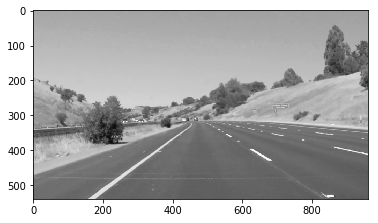

In [235]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [186]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

std m pos 0.285477681602
std m pos 0.280013450886
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  1%|          | 2/251 [00:00<00:12, 19.65it/s]

std m pos 0.285477681602
std m pos 0.280013450886
std m pos 0.373073149602
std m pos 0.296156498416
std m pos 0.281517649273
std m pos 0.25878352661


  2%|▏         | 4/251 [00:00<00:12, 19.58it/s]

std m pos 0.292066049262
std m pos 0.284195188439


  2%|▏         | 6/251 [00:00<00:12, 18.99it/s]

std m pos 0.177293608831
std m pos 0.256651449383
std m pos 0.343275120945
std m pos 0.260187539767
std m pos 0.237856137442
std m pos 0.276229633685
std m pos 0.268571171158
std m pos 0.251516966779


  4%|▍         | 10/251 [00:00<00:13, 17.34it/s]

std m pos 0.273861327157
std m pos 0.273872353085
std m pos 0.196006708391
std m pos 0.291018790506
std m pos 0.300547863834
std m pos 0.314721994544


  5%|▍         | 12/251 [00:00<00:13, 17.89it/s]

std m pos 0.310534293329
std m pos 0.291725689897


  6%|▌         | 14/251 [00:00<00:12, 18.39it/s]

std m pos 0.259861240588
std m pos 0.27073166978
std m pos 0.367255953671
std m pos 0.27616917286
std m pos 0.253361063965
std m pos 0.272338142016


  6%|▋         | 16/251 [00:00<00:12, 18.58it/s]

std m pos 0.230235107089
std m pos 0.27245216658
std m pos 0.219823894571
std m pos 0.287008674228


  7%|▋         | 18/251 [00:00<00:12, 18.70it/s]

std m pos 0.31785054914
std m pos 0.281174200891
std m pos 0.247410826084
std m pos 0.274989935568


  8%|▊         | 20/251 [00:01<00:13, 17.19it/s]

std m pos 0.237439315857
std m pos 0.264089522133


  9%|▉         | 22/251 [00:01<00:14, 16.34it/s]

std m pos 0.261550787341
std m pos 0.256221308291
std m pos 0.274888441978
std m pos 0.238267317807
std m pos 0.478340009362
std m pos 0.279538531026


 10%|▉         | 24/251 [00:01<00:13, 16.70it/s]

std m pos 0.23093286071
std m pos 0.271102873774


 10%|█         | 26/251 [00:01<00:13, 16.86it/s]

std m pos 0.388467546243
std m pos 0.233592976827
std m pos 0.353784926471
std m pos 0.278525855731
std m pos 0.247356792828
std m pos 0.290455769449


 11%|█         | 28/251 [00:01<00:13, 16.31it/s]

std m pos 0.233797763738
std m pos nan


 12%|█▏        | 30/251 [00:01<00:13, 16.65it/s]

std m pos 0.466145298393
std m pos 0.284964335498
std m pos 0.566975884486
std m pos 0.272991537564
std m pos 0.503891248937
std m pos 0.301176345113


 13%|█▎        | 32/251 [00:01<00:13, 16.76it/s]

std m pos 0.38551471648
std m pos 0.331828610827


 14%|█▎        | 34/251 [00:01<00:13, 16.19it/s]

std m pos 0.408185641016
std m pos 0.286564266609
std m pos 0.372502048443
std m pos 0.287281300048


 14%|█▍        | 36/251 [00:02<00:13, 15.76it/s]

std m pos 0.389545705204
std m pos 0.279193142521
std m pos 0.328668514091
std m pos 0.257842050002


 15%|█▌        | 38/251 [00:02<00:13, 15.95it/s]

std m pos 0.390840043363
std m pos 0.216233184097
std m pos 0.375539095503
std m pos 0.275038977809
std m pos 0.435249144684
std m pos 0.247562812203


 16%|█▌        | 40/251 [00:02<00:13, 15.22it/s]

std m pos 0.37564474158
std m pos 0.238953595695
std m pos 0.414412431774
std m pos 0.258589955622


 17%|█▋        | 42/251 [00:02<00:13, 15.29it/s]

std m pos 0.392830603421
std m pos 0.246924547432
std m pos 0.436165873525
std m pos 0.240472815454


 18%|█▊        | 44/251 [00:02<00:13, 14.94it/s]

std m pos 0.391861948374
std m pos nan


 18%|█▊        | 46/251 [00:02<00:13, 14.69it/s]

std m pos 0.305338443022
std m pos 0.258377830208
std m pos 0.31253522094
std m pos 0.261512068171
std m pos 0.388891132799
std m pos 0.249532884396
std m pos

 20%|█▉        | 50/251 [00:03<00:13, 15.13it/s]

 0.485006893522
std m pos 0.411011122412
std m pos 0.336383851621
std m pos 0.279414549831
std m pos 0.43745966877
std m pos 0.356952378415
std m pos 3.81060479869
std m pos 6.78776891846


 22%|██▏       | 54/251 [00:03<00:12, 16.22it/s]

std m pos 0.390588932234
std m pos 0.284943219591
std m pos 0.322696270936
std m pos 0.27386858486
std m pos 0.833132678641
std m pos nan
std m pos 0.245136934697
std m pos 0.595002811678


 23%|██▎       | 58/251 [00:03<00:10, 17.59it/s]

std m pos 0.310689078359
std m pos 0.811761195924
std m pos 0.367181872676
std m pos 0.232221159359
std m pos 0.749948573443
std m pos nan
std m pos 0.193483606542
std m pos 0.332539029664
std m pos 1.24941207732
std m pos 0.903596264094


 24%|██▍       | 61/251 [00:03<00:10, 18.10it/s]

std m pos 0.257549697082
std m pos 0.56061927079
std m pos 0.308164815951
std m pos 0.990853756437


 25%|██▌       | 63/251 [00:03<00:10, 18.29it/s]

std m pos 5.66274721935
std m pos nan
std m pos 0.436152971651
std m pos 1.86094442949


 26%|██▋       | 66/251 [00:03<00:09, 18.58it/s]

std m pos 2.2686012977
std m pos nan
std m pos 2.53306395472
std m pos nan


 27%|██▋       | 68/251 [00:04<00:10, 17.69it/s]

std m pos 1.04841552741
std m pos nan
std m pos 2.82156234113
std m pos 2.7424479993


 28%|██▊       | 70/251 [00:04<00:09, 18.24it/s]

std m pos 5.40597721219
std m pos 3.00864271225
std m pos 2.86816504645
std m pos nan
std m pos 1.71016213487
std m pos 2.5290546026
std m pos 0.44483684442
std m pos nan


 29%|██▊       | 72/251 [00:04<00:10, 16.47it/s]

std m pos 2.44774986681
std m pos 2.46756376531


 30%|███       | 76/251 [00:04<00:10, 16.65it/s]

std m pos 10.8407010911
std m pos nan
std m pos 9.65435125257
std m pos 0.392376121044
std m pos 4.93656272665
std m pos nan
std m pos 2.9826793345
std m pos 0.58263870805


 31%|███       | 78/251 [00:04<00:10, 16.77it/s]

std m pos 3.48619874372
std m pos 0.225919444237
std m pos 4.20246547875
std m pos nan


 32%|███▏      | 80/251 [00:04<00:10, 15.98it/s]

std m pos 1.20628994033
std m pos 5.63969813954


 33%|███▎      | 82/251 [00:04<00:10, 16.63it/s]

std m pos 5.30343983334
std m pos 0.244915128062
std m pos 2.90587996176
std m pos 0.369606974217
std m pos 2.99782071834
std m pos 0.540946814586


 33%|███▎      | 84/251 [00:05<00:09, 17.18it/s]

std m pos 1.25880700984
std m pos 1.09810556343


 34%|███▍      | 86/251 [00:05<00:09, 17.11it/s]

std m pos 3.61019015199
std m pos 0.389173654566
std m pos 4.15925164422
std m pos 0.32386598579
std m pos 2.7343198602
std m pos 0.873664842951
std m pos 5.60136000805


 36%|███▌      | 90/251 [00:05<00:09, 16.42it/s]

std m pos 0.330556132772
std m pos 3.80720609304
std m pos 0.41379076833
std m pos 4.35664983517
std m pos 0.269680547817
std m pos 4.13153716582
std m pos 1.52521160922


 37%|███▋      | 94/251 [00:05<00:10, 15.45it/s]

std m pos 4.7308037521
std m pos 0.357733854478
std m pos 6.17598371113
std m pos 0.459403202067
std m pos 0.561896544031
std m pos 0.41801088585


 38%|███▊      | 96/251 [00:05<00:10, 14.43it/s]

std m pos 1.1719824793
std m pos 0.376597557311
std m pos 7.68032089013
std m pos nan
std m pos 0.345076053309
std m pos nan


 40%|███▉      | 100/251 [00:06<00:10, 14.29it/s]

std m pos 0.624725564565
std m pos 0.273143185531
std m pos 3.64893973058
std m pos 0.304335395168
std m pos 1.5136698779
std m pos 0.262594545784


 41%|████▏     | 104/251 [00:06<00:10, 14.68it/s]

std m pos 0.214288292884
std m pos 1.97772341607
std m pos 2.92815862531
std m pos 0.852569127075
std m pos 0.469517038699
std m pos 0.341475703878
std m pos 0.301720918935
std m pos 0.827613803822


 42%|████▏     | 106/251 [00:06<00:09, 14.53it/s]

std m pos 0.809011391892
std m pos 0.746828607174
std m pos 0.364416333327
std m pos 1.09302356962
std m pos 0.728742913851
std m pos 0.224068481109


 44%|████▍     | 110/251 [00:06<00:10, 13.55it/s]

std m pos 0.292825926547
std m pos 0.865320583247
std m pos 2.62221896995
std m pos 0.266322367613
std m pos 0.387916332239
std m pos 0.177839492988


 45%|████▍     | 112/251 [00:06<00:09, 14.21it/s]

std m pos 4.1463339728
std m pos nan
std m pos 1.04787611502
std m pos 0.276840846188
std m pos 1.24447353172
std m pos 1.24523832165
std m pos 0.281957035659
std m pos 0.327710420655


 47%|████▋     | 117/251 [00:07<00:08, 16.27it/s]

std m pos 0.298654266529
std m pos 0.408393454704
std m pos 3.52928606026
std m pos 0.414446030461
std m pos 0.880867110555
std m pos 0.368619680176
std m pos 0.584871220676
std m pos 0.769462025248


 49%|████▊     | 122/251 [00:07<00:07, 16.81it/s]

std m pos 0.513271017301
std m pos 0.414886257689
std m pos 1.65569979088
std m pos 0.257413055828
std m pos 0.481454730305
std m pos nan
std m pos 2.28184904455
std m pos 0.508491881125


 49%|████▉     | 124/251 [00:07<00:07, 16.81it/s]

std m pos 1.42833359725
std m pos 6.97389341363
std m pos 1.34716180146
std m pos 1.66207945049
std m pos 6.93265556832
std m pos 2.3161162737


 51%|█████     | 128/251 [00:07<00:08, 15.24it/s]

std m pos 0.252114007605
std m pos 0.951008596934
std m pos 2.03930104885
std m pos 5.92213280693
std m pos 3.39215538274
std m pos nan
std m pos 4.62974183058
std m pos 4.10009209114


 53%|█████▎    | 132/251 [00:08<00:07, 15.82it/s]

std m pos 2.51072258356
std m pos 0.402951354961
std m pos 0.283190435756
std m pos 0.368778455249
std m pos 0.317060743482
std m pos 1.50693681189
std m pos 0.280474489032
std m pos 0.481067124479


 55%|█████▍    | 137/251 [00:08<00:06, 17.01it/s]

std m pos 0.865560083792
std m pos 0.331270089441
std m pos 0.949971494312
std m pos nan
std m pos 0.419148412946
std m pos 0.321663841312
std m pos 1.9428906813
std m pos 0.394427409522
std m pos 0.559956365087
std m pos 0.458119714804


 56%|█████▌    | 141/251 [00:08<00:06, 16.46it/s]

std m pos 0.181948571389
std m pos 0.333844696294
std m pos 0.243264481381
std m pos 0.26181026459
std m pos 0.305683425623
std m pos 0.311776019982


 57%|█████▋    | 143/251 [00:08<00:06, 16.65it/s]

std m pos 0.200163219054
std m pos 0.194702836202
std m pos 0.247223478822
std m pos 0.158555166167
std m pos 0.246895091831
std m pos 0.213670947308
std m pos 0.323774618666
std m pos 0.158740458662


 59%|█████▉    | 148/251 [00:09<00:06, 16.23it/s]

std m pos 0.221769270025
std m pos 0.166930581587
std m pos 0.223205057523
std m pos 0.143119148262
std m pos 0.152159868732
std m pos 0.18779656689


 61%|██████    | 153/251 [00:09<00:05, 17.24it/s]

std m pos 0.145989893927
std m pos 0.182881539019
std m pos 0.298423611825
std m pos 0.892720909014
std m pos 0.241331295281
std m pos 0.200274280769
std m pos 0.402367143779
std m pos 0.232864864999
std m pos 0.270440309397
std m pos 0.297706239197


 63%|██████▎   | 157/251 [00:09<00:05, 16.96it/s]

std m pos 0.322969513122
std m pos 0.201164585587
std m pos 0.328029842553
std m pos 0.210490192006
std m pos 0.319831997652
std m pos 0.248068212737
std m pos 0.297478017142
std m pos 0.214825667368


 63%|██████▎   | 159/251 [00:09<00:05, 16.33it/s]

std m pos 0.303093597414
std m pos 0.245682137236
std m pos 0.331673677728
std m pos 0.22868816776
std m pos 0.235025687526
std m pos 0.246810870619


 65%|██████▍   | 163/251 [00:09<00:05, 16.28it/s]

std m pos 0.319032094353
std m pos 0.243151760627
std m pos 0.29341433682
std m pos 0.217640526159
std m pos 0.302315431744
std m pos 0.257177637795
std m pos 0.290251711154
std m pos 0.225807740034


 67%|██████▋   | 167/251 [00:10<00:04, 17.56it/s]

std m pos 0.277373138014
std m pos 0.231940965505
std m pos 0.270916839099
std m pos 0.218064338076
std m pos 0.289637011415
std m pos 0.239295148725
std m pos 0.28825188612
std m pos 0.222538276801


 68%|██████▊   | 171/251 [00:10<00:04, 17.64it/s]

std m pos 0.2944818768
std m pos 0.215582215787
std m pos 0.348661459201
std m pos 0.248413729888
std m pos 0.246744314778
std m pos 0.240594652132
std m pos 0.277536348943
std m pos 0.223895300258


 70%|██████▉   | 175/251 [00:10<00:04, 17.26it/s]

std m pos 0.286681911875
std m pos 0.252087880538
std m pos 0.329018931122
std m pos 0.261501907309
std m pos 0.294510556279
std m pos 0.242887169965
std m pos 0.232668816995
std m pos 0.240654428945


 72%|███████▏  | 180/251 [00:10<00:03, 18.35it/s]

std m pos 0.263209658834
std m pos 0.292669569059
std m pos 0.259137229949
std m pos 0.267491366902
std m pos 0.260613016126
std m pos 0.257990165801
std m pos 0.220888818387
std m pos 0.238929861565


 73%|███████▎  | 184/251 [00:11<00:03, 16.94it/s]

std m pos 0.204878265232
std m pos 0.274650164044
std m pos 0.200799219037
std m pos 0.266181042847
std m pos 0.261939021045
std m pos 0.233967787595
std m pos 0.282352894495
std m pos 0.248211305221


 75%|███████▍  | 188/251 [00:11<00:03, 18.06it/s]

std m pos 0.280639477999
std m pos 0.252905963252
std m pos 0.389636012428
std m pos 0.266927020119
std m pos 0.235399194835
std m pos 0.266588631687
std m pos 0.246967785575
std m pos 0.249934812149


 76%|███████▋  | 192/251 [00:11<00:03, 17.11it/s]

std m pos 0.237514274209
std m pos 0.26309315386
std m pos 0.281813870171
std m pos 0.296879322939
std m pos 0.342215058553
std m pos 0.280131921481
std m pos 0.342703385324
std m pos 0.27370657135


 78%|███████▊  | 196/251 [00:11<00:03, 16.22it/s]

std m pos 0.314042905465
std m pos 0.281165515949
std m pos 0.23824278934
std m pos 0.289452750195
std m pos 0.24041797962
std m pos 0.24670558681
std m pos 0.274952748052
std m pos 0.273179726693


 80%|███████▉  | 200/251 [00:12<00:02, 17.07it/s]

std m pos 0.225181427153
std m pos 0.281385338873
std m pos 0.376462985501
std m pos 0.271546721069
std m pos 0.295481613399
std m pos 0.298720118549
std m pos 1.73339842399
std m pos 0.244689389186


 81%|████████▏ | 204/251 [00:12<00:02, 16.47it/s]

std m pos 0.0474230682555
std m pos 0.258562654406
std m pos 0.315250765263
std m pos 0.283497474748
std m pos 0.262579034011
std m pos 0.27370562966
std m pos 0.215758242372
std m pos 0.256878239192


 83%|████████▎ | 208/251 [00:12<00:02, 16.64it/s]

std m pos 0.298372379897
std m pos 0.263986134957
std m pos 0.255174570214
std m pos 0.280294816051
std m pos 0.207672058064
std m pos 0.263913082311
std m pos 0.269127029421
std m pos 0.243982128916


 84%|████████▎ | 210/251 [00:12<00:02, 16.43it/s]

std m pos 0.224074547134
std m pos 0.290891529206
std m pos 0.262727943553
std m pos 0.265366390389
std m pos 0.29408842773
std m pos 0.503002619748
std m pos 0.209743379144
std m pos 0.272019811304


 86%|████████▌ | 216/251 [00:13<00:02, 16.93it/s]

std m pos 0.232279836376
std m pos 0.248890974254
std m pos 0.245773811122
std m pos 0.300584967813
std m pos 0.272433641957
std m pos 0.29146191547
std m pos 0.275351206423
std m pos 0.291498233918


 88%|████████▊ | 220/251 [00:13<00:01, 17.50it/s]

std m pos 0.266310251157
std m pos 0.262721530252
std m pos 0.232247957797
std m pos 0.265798991149
std m pos 0.252933712231
std m pos 0.255539085966
std m pos 0.199707090793
std m pos 0.289973828279


 89%|████████▉ | 224/251 [00:13<00:01, 18.36it/s]

std m pos 0.217932805065
std m pos 0.276823734909
std m pos 0.752532470989
std m pos 0.267742505464
std m pos 6.38582187315
std m pos 0.307303916849
std m pos 5.08910960253
std m pos 0.284839758362


 91%|█████████ | 228/251 [00:13<00:01, 17.70it/s]

std m pos 7.12205493591
std m pos 0.286654024497
std m pos 5.68820795731
std m pos 0.267154711086
std m pos 0.192479733955
std m pos 0.354401560064
std m pos 0.328251569639
std m pos 0.346583604638


 92%|█████████▏| 230/251 [00:13<00:01, 17.02it/s]

std m pos 0.492532023805
std m pos 0.306325017968
std m pos 0.527701623203
std m pos 0.320867428125
std m pos 0.216923614768
std m pos 0.296352671489
std m pos 0.300929333193
std m pos 0.288451911645


 93%|█████████▎| 234/251 [00:14<00:01, 15.73it/s]

std m pos 0.295172728064
std m pos 3.284428789
std m pos 0.262104962646
std m pos 0.245434237128
std m pos 0.2412070481
std m pos 0.258846369056


 95%|█████████▍| 238/251 [00:14<00:00, 14.43it/s]

std m pos 0.269742693422
std m pos 0.297397199243
std m pos 0.245347961261
std m pos 0.28658728292
std m pos 0.230741758319
std m pos 0.281386775175


 96%|█████████▌| 240/251 [00:14<00:00, 14.89it/s]

std m pos 0.322759342945
std m pos 1.90145460143
std m pos 0.226461793876
std m pos 0.281499641968
std m pos 0.39872850908
std m pos 0.273848945185


 97%|█████████▋| 244/251 [00:14<00:00, 14.70it/s]

std m pos 0.20214295813
std m pos 0.26813524254
std m pos 0.232655537668
std m pos 0.275279854773
std m pos 0.239917565305
std m pos 0.27463619304
std m pos 0.212574274256
std m pos 0.291336621406


 99%|█████████▉| 248/251 [00:15<00:00, 14.93it/s]

std m pos 0.162144413704
std m pos 0.302757091636
std m pos 0.21876349553
std m pos 0.269333288155
std m pos 0.218351816758
std m pos 0.282774698628


100%|██████████| 251/251 [00:15<00:00, 16.44it/s]


std m pos 0.227826607343
std m pos 0.295455222625
std m pos 0.175242296585
std m pos 0.245445761151
std m pos 0.187608514233
std m pos 0.274751914846
[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 54.6 s, sys: 576 ms, total: 55.2 s
Wall time: 16.2 s


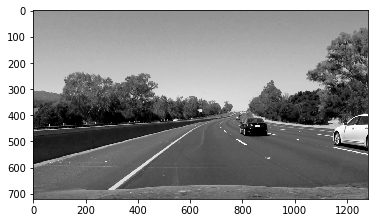

In [238]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))